# **Financial Time Series Forecasting**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!pip install --quiet ipython-autotime pandas_gbq
%load_ext autotime

time: 769 µs (started: 2021-09-01 19:15:29 +00:00)


## **Load Data**

In [60]:
# Insolvenzverfahren

_FINANCE_PROJECT_NAME = u"lunar-demo"

def run_finance_query(query, index_col="year"):
  return pd.read_gbq(
    query,
    project_id=_FINANCE_PROJECT_NAME,
    index_col=index_col,
    dialect="standard").sort_index()

google_raw = run_finance_query(
    "SELECT * FROM `lunar-demo.repo.google_raw` order by year asc")

google_raw.head()

,month,day,open,close,high,low,volume
year,,,,,,,
2004,12,30,70.55,70.75,70.95,70.40,1.21
2004,12,29,70.50,70.90,71.04,70.35,2.96
2004,12,28,70.40,70.49,70.80,70.40,1.37
2004,12,27,69.45,70.50,70.95,69.43,1.57
2004,12,23,69.45,69.65,69.65,68.85,1.59


time: 1.67 s (started: 2021-09-01 20:14:01 +00:00)


### **Preprocess Time Series**

**Create proper datetime**

In [68]:
# Copy table (recopy raw table, um bei fehlern die originaltabelle nicht immer neu herunterladen zu muessen)
google = google_raw.copy()

# Reset index
google = google.reset_index()

# Create date time
google['date'] = pd.to_datetime(google[['year', 'month', 'day']], utc=True)

# Set index
google = google.set_index('date')

# Drop unnecessary columns
google = google.drop(['year', 'month', 'day'], axis=1)

# Sort date
google = google.sort_index() #inplace=True, ascending=True)

google.head()

,open,close,high,low,volume
date,,,,,
2004-08-30 00:00:00+00:00,43.70,42.70,43.85,42.60,2.12
2004-08-31 00:00:00+00:00,42.30,42.25,42.55,42.03,3.79
2004-09-01 00:00:00+00:00,42.10,41.30,42.30,41.15,3.59
2004-09-02 00:00:00+00:00,41.00,41.28,41.35,40.60,5.58
2004-09-03 00:00:00+00:00,41.08,41.50,41.85,41.08,1.70


time: 27 ms (started: 2021-09-01 20:18:49 +00:00)


**Make statistical analysis**

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


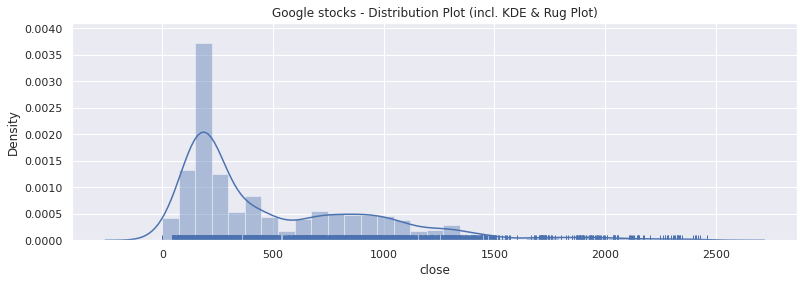

time: 319 ms (started: 2021-09-01 20:18:52 +00:00)


In [69]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((google.close), hist=True, rug=True).set_title('Google stocks - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

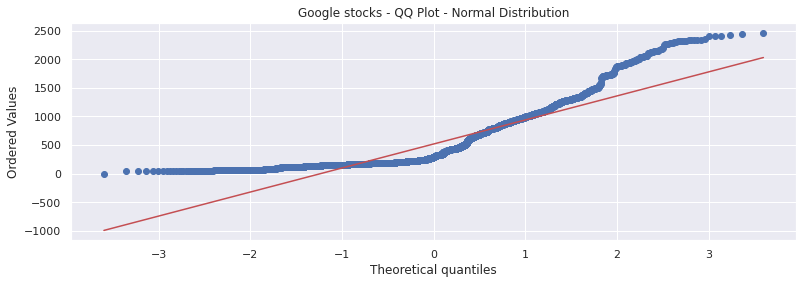

time: 209 ms (started: 2021-09-01 20:19:42 +00:00)


In [70]:
import scipy
from scipy import stats
stats.probplot(google.close, dist="norm", plot=plt)
plt.title('Google stocks - QQ Plot - Normal Distribution')
plt.show()

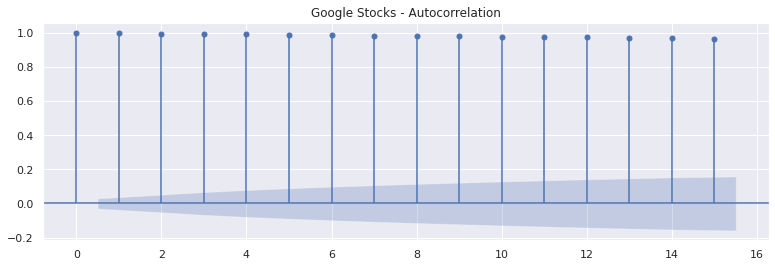

time: 443 ms (started: 2021-09-01 20:20:17 +00:00)


In [71]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(google.close.squeeze(), lags=15)
plt.title('Google Stocks - Autocorrelation')
plt.show()

**Add column for differenced and normalized values**

In [64]:
# Add differences
google = google.diff(axis=0)

# Normalize
google = google.apply(lambda x: x/x.max(), axis=0)

# Remove nan
google = google.dropna()

# Turn into ing with no decimals
google = google.round(decimals=4)

# Display preprocessed & cleaned table
google.head()

,open,close,high,low,volume
date,,,,,
2004-09-01 00:00:00+00:00,0.0051,0.0,0.005,0.0,-0.0000
2004-09-02 00:00:00+00:00,0.0000,0.0,0.000,0.0,0.0000
2004-09-03 00:00:00+00:00,0.0000,0.0,0.000,0.0,-0.0000
2004-09-06 00:00:00+00:00,0.0000,0.0,-0.000,0.0,0.1282
2004-09-07 00:00:00+00:00,0.0000,0.0,0.000,-0.0,-0.2564


time: 21.9 ms (started: 2021-09-01 20:14:24 +00:00)


**Display table**

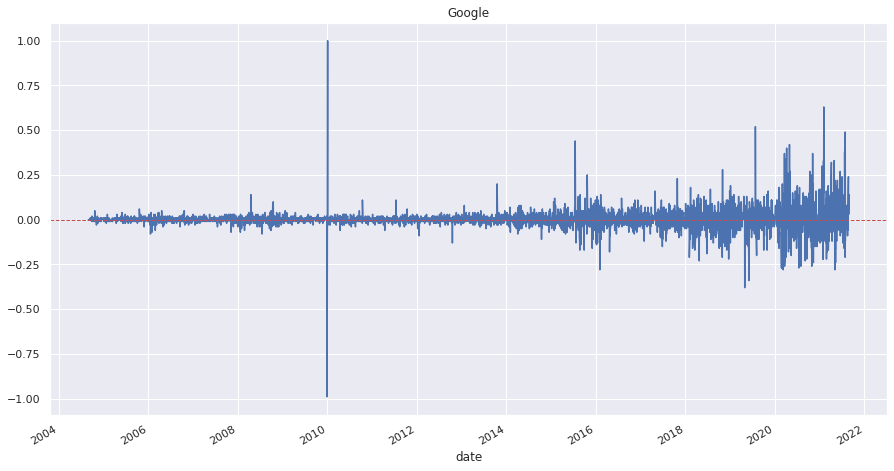

time: 355 ms (started: 2021-09-01 20:14:18 +00:00)


In [63]:
# Display Data
sns.set(rc={'figure.figsize':(15, 8)})
google.close.plot(title='Google')
plt.axhline(0, linewidth=1, color='r', ls='--')

**Zoom in on timeframes**

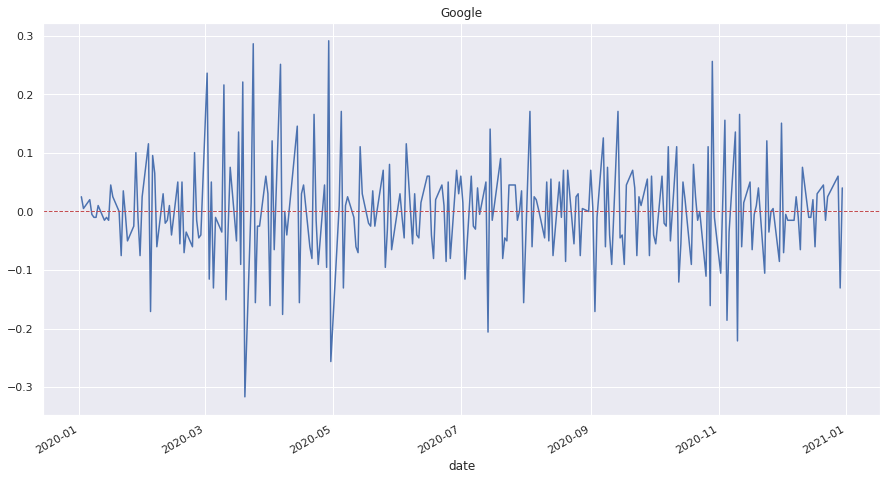

time: 339 ms (started: 2021-09-01 20:14:40 +00:00)


In [65]:
# Display Data during peak
resample = google.close['2020-01-01':'2021-01-01']
sns.set(rc={'figure.figsize':(15, 8)})
resample.plot(title='Google')
plt.axhline(0, linewidth=1, color='r', ls='--')

**Save preprocessed table in Bigquery**

In [66]:
# Send copy as new table to BigQuery
google = google.reset_index()
project_id = !gcloud config get-value project
google.to_gbq('repo.google', project_id=project_id[0], if_exists='replace')

1it [00:05,  5.67s/it]

time: 6.97 s (started: 2021-09-01 20:15:08 +00:00)


### **Train Autoregressive Model (Arima)**

*Trainieren eines Arima-Models auf Basis der taglichen Differenzen der Insolvenzen in Schleswig Holstein. Dokumentation: [bigqueryml-syntax-create](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create) bzw. [bigqueryml-syntax-create-time-series](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series)*

In [54]:
%%bigquery
CREATE OR REPLACE MODEL `lunar-demo.repo.arima`
 OPTIONS(MODEL_TYPE='ARIMA',
         time_series_timestamp_col='date',
         time_series_data_col='close') AS
SELECT
  date,
  close
FROM
  `lunar-demo.repo.google`

""


time: 1min 29s (started: 2021-09-01 20:07:18 +00:00)


In [55]:
%%bigquery
SELECT * 
FROM ML.ARIMA_COEFFICIENTS(MODEL repo.arima)

,ar_coefficients,ma_coefficients,intercept_or_drift
0,[],"[-0.13469456139578206, 0.0025103384351321018, ...",-0.000211


time: 1.77 s (started: 2021-09-01 20:08:57 +00:00)


In [56]:
%%bigquery
SELECT * 
FROM ML.EVALUATE(MODEL repo.arima)

,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods
0,0,0,5,False,17675.030079,-35336.060157,0.000196,[NO_SEASONALITY]
1,3,0,2,False,17674.665451,-35335.330903,0.000196,[NO_SEASONALITY]
2,5,0,0,False,17674.505489,-35335.010978,0.000196,[NO_SEASONALITY]
3,4,0,1,False,17672.402367,-35330.804733,0.000196,[NO_SEASONALITY]
4,4,0,0,False,17670.752592,-35329.505185,0.000196,[NO_SEASONALITY]
5,2,0,3,False,17671.545614,-35329.091228,0.000196,[NO_SEASONALITY]
6,1,0,4,False,17671.216482,-35328.432965,0.000196,[NO_SEASONALITY]
7,3,0,1,False,17669.508778,-35327.017555,0.000196,[NO_SEASONALITY]
8,1,0,3,False,17668.257745,-35324.515489,0.000197,[NO_SEASONALITY]
9,0,0,4,False,17667.188278,-35322.376555,0.000197,[NO_SEASONALITY]


time: 2.93 s (started: 2021-09-01 20:09:05 +00:00)


**Make Forecasts** 

*Dokumentation: https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-forecast*

In [57]:
arima_prediction = pd.io.gbq.read_gbq('''
SELECT * 
FROM ML.FORECAST(MODEL repo.arima,
              STRUCT(7 AS horizon, 0.8 AS confidence_level));
''')

arima_prediction = arima_prediction.set_index('forecast_timestamp')

arima_prediction.head()

,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
forecast_timestamp,,,,,,,
2021-08-31 00:00:00+00:00,0.003316,0.014005,0.8,-0.014641,0.021274,-0.014641,0.021274
2021-09-01 00:00:00+00:00,-0.000430,0.014131,0.8,-0.018550,0.017690,-0.018550,0.017690
2021-09-02 00:00:00+00:00,-0.000480,0.014131,0.8,-0.018600,0.017640,-0.018600,0.017640
2021-09-03 00:00:00+00:00,-0.000339,0.014139,0.8,-0.018469,0.017791,-0.018469,0.017791
2021-09-04 00:00:00+00:00,-0.000417,0.014162,0.8,-0.018577,0.017742,-0.018577,0.017742


time: 1.27 s (started: 2021-09-01 20:09:12 +00:00)


**Visualisierung der Forecasts**

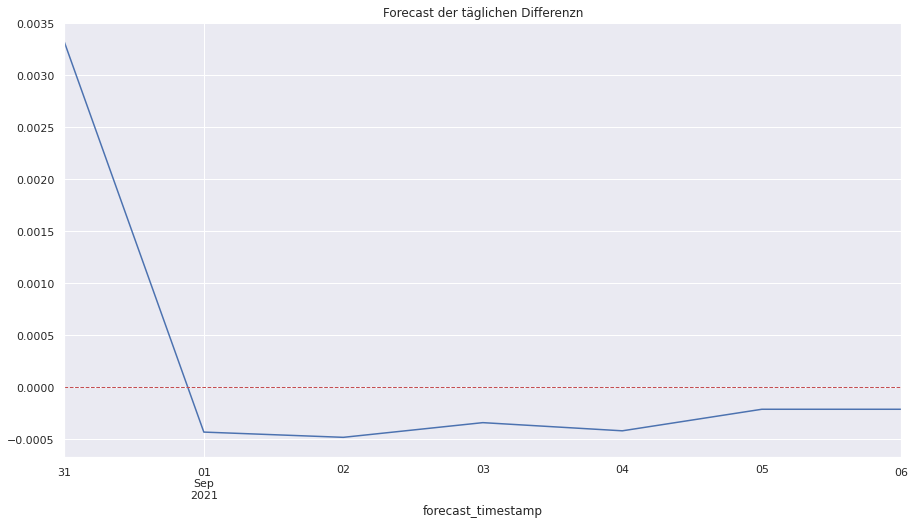

time: 284 ms (started: 2021-09-01 20:09:34 +00:00)


In [58]:
# Display predictions
sns.set(rc={'figure.figsize':(15, 8)})
arima_prediction.forecast_value.plot(title='Forecast der täglichen Differenzn')
plt.axhline(0, linewidth=1, color='r', ls='--')

In [59]:
# Send forecasts as new table to BigQuery
arima_prediction = arima_prediction.reset_index()
project_id = !gcloud config get-value project
arima_prediction.to_gbq('repo.arima_prediction', project_id=project_id[0], if_exists='replace')

1it [00:05,  5.10s/it]

time: 6.4 s (started: 2021-09-01 20:09:57 +00:00)
